In [38]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Add details to colored mask

In [46]:
def style_transfer(img_path, color_path, maximize_color=True, bilateral = True, color_weight=0.5, details_weight=0.5,
                  crop = False, white_bg = False):
    # read images
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    # TODO: vedere controllo sfondo uniforme -> no bilaterale
    img, mask = get_edge_segmentation(img_path, bilateral=bilateral, crop=crop, white_bg=white_bg)
    color = cv2.imread(color_path)
    # get image details
    details = get_image_details(img)
    # resize color to fit the mask
    color = cv2.resize(color, (img.shape[1], img.shape[0]))
    # apply color to the mask
    mask_colored = cv2.bitwise_and(mask, color)
    # uniformate np types
    img = img.astype('uint8')
    mask_colored = mask_colored.astype('uint8')
    mask = mask.astype('uint8')
    details = details.astype('uint8')
    # fill empty areas of details with colored mask to emphasizes the style transfer
    if maximize_color:
        details = np.where(details > 235, mask_colored, details)
        plt.imshow(cv2.cvtColor(details, cv2.COLOR_BGR2RGB))
        plt.show()
    # create final image as weighted sum between details and colored mask
    img_final = mask_colored.copy()
    img_final = cv2.addWeighted(mask_colored, color_weight, details, details_weight, 0, -1)
    # refilter backround
    img_final = cv2.bitwise_and(img_final, mask)
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
    ax[2].imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    return img_final
    

def get_image_details(img):
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # apply gaussian blut
        img = cv2.GaussianBlur(img, (3,3), 0)
        # inverted image
        inv_image = 255 - img
        # detect edges from both the blurred image and its negative
        edges_blurred = detect_edges(img)
        edges_inverted = detect_edges(inv_image)
        # combine edges
        img_edges = cv2.addWeighted(edges_blurred, 1, edges_inverted, 1, 0)
        # invert back image
        img = 255 - img_edges    
        
        plt.imshow(img, cmap='gray')
        plt.show()
        # convert back to bgr
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img


def detect_edges(img):
    horizontal = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
    vertical = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
    # combine both vertical and horizontal edges
    combined_edges = cv2.bitwise_or(horizontal, vertical)
    return combined_edges

def get_edge_segmentation(img_path, bilateral = True, resize = False, crop = False, white_bg = False):
    # read img
    img = cv2.imread(img_path)
    # convert to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resize
    img_resized = img_rgb.copy()
    if resize:
        img_resized = cv2.resize(img_rgb, (250,250))
    # apply bilateral filter
    img_filtered = img_resized.copy()
    if bilateral:
        img_filtered = cv2.bilateralFilter(img_resized,45,200,40, cv2.BORDER_REFLECT)
        plt.imshow(img_filtered)
        plt.show()
    # extract edges
    canny = cv2.Canny(img_filtered, 100,  150) 
    plt.imshow(canny, cmap='gray')#
    plt.show()#
    # find contours from edges
    contours, _ = cv2.findContours(canny, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    if len(contours) > 10:
        contours = contours[:10]
    # draw contours on the image
    new_image = img_resized.copy()
    cv2.drawContours(new_image, contours, -1, (255, 0, 0), 2)
    plt.imshow(new_image)#
    plt.show()#
    # Get convex hull for max contours and draw them
    unified=[]
    conts = np.vstack(contours)
    hull = cv2.convexHull(conts)
    unified.append(hull)
    cv2.drawContours(new_image,unified,-1,(0,0,255),3)
    plt.imshow(new_image)#
    plt.show()#
    # First create our rectangle that contains the object
    x_min = min(hull[:, 0, 0])
    x_max = max(hull[:, 0, 0])
    y_min = min(hull[:, 0, 1])
    y_max = max(hull[:, 0, 1])
    width = x_max - x_min
    height = y_max - y_min
    rect = (x_min,y_min,width,height)
    # create mask
    mask = np.zeros(img_resized.shape[:2],np.uint8)
    # set values for grabCut
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    # segmentation
    cv2.grabCut(img_resized,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    plt.imshow(mask)#
    plt.show()
    mask2 = np.where(((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD)),0,1).astype('uint8')
    img = img_resized*mask2[:,:,np.newaxis]
    # prepare mask
    mask2 = cv2.cvtColor(mask2*255, cv2.COLOR_GRAY2BGR)
    # crop image with the region of interest
    if crop:
        img = img[y_min:y_max, x_min:x_max]
        mask2 = mask2[y_min:y_max, x_min:x_max]
    # invert background color
    if white_bg:
        img = img + (255 - mask2)
    return img, mask2

    

    

In [47]:
color_path = '../test_imgs/lv.png'
img_path = '../test_imgs/bag.jpg'

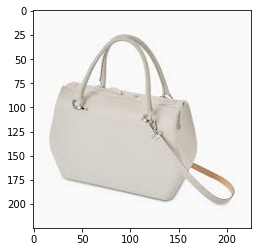

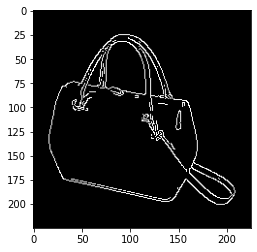

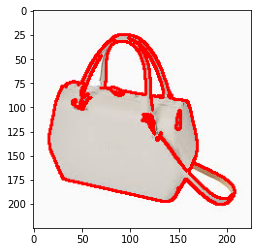

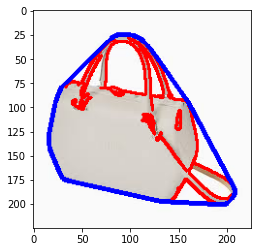

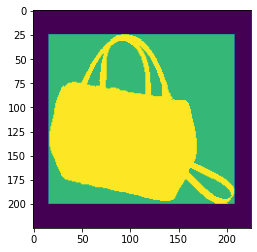

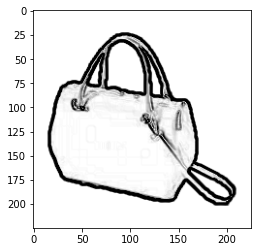

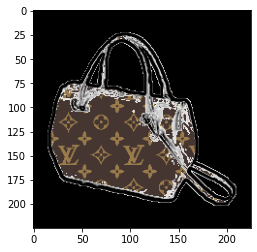

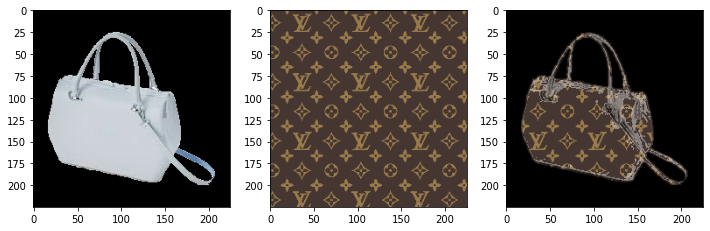

In [48]:
# provalah
new = style_transfer(img_path, color_path, maximize_color = True, bilateral = False)

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

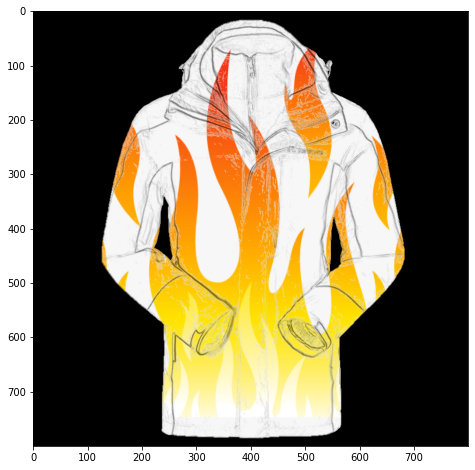

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))
plt.imshow

# Middle version

In [ ]:
color_path = '../test_imgs/bg_1.jpg'
img_path = '../test_imgs/bg_uniform_1.jpg'
mask_path = '../test_imgs/jacket_mask.bmp'
details_path ='../test_imgs/jacket_details.jpg'

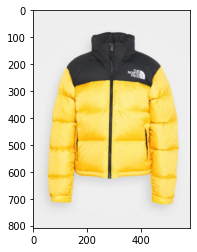

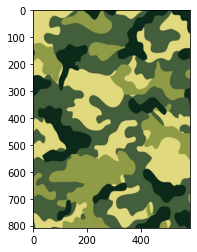

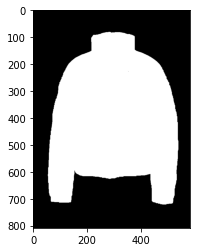

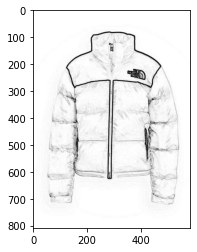

In [36]:
# read images
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color = cv2.imread(color_path)
color = cv2.resize(color, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.imread(mask_path)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()
details = cv2.imread(details_path)
plt.imshow(cv2.cvtColor(details, cv2.COLOR_BGR2RGB))
plt.show()

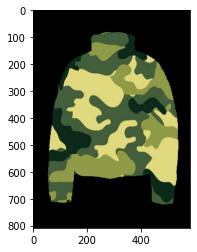

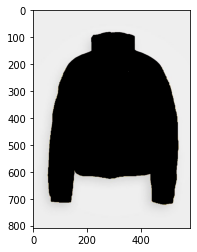

In [133]:
# prepare values for color multiplication
mask = np.where(mask == 255, 1, 0)
mask_complement = np.where(mask == 0, 1, 0)
mask_colored = mask * color
plt.imshow(cv2.cvtColor(np.float32(mask_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# to preserve the background
mask_complement_colored = mask_complement * img
plt.imshow(cv2.cvtColor(np.float32(mask_complement_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# bah
img = img.astype('uint8')
mask_colored = mask_colored.astype('uint8')
mask = mask.astype('uint8')
details = details.astype('uint8')
img_colored = mask_colored.copy()

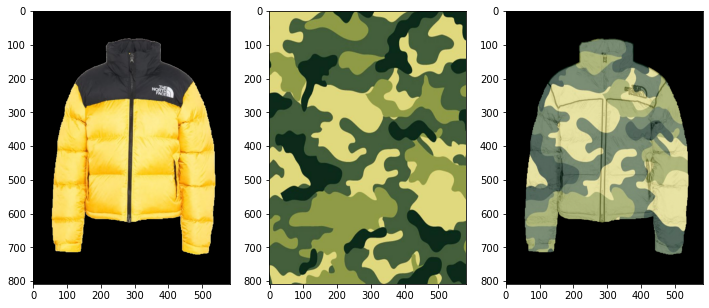

In [157]:
# weighted sum
img_colored = cv2.addWeighted(mask_colored, 0.7, details, 0.3, 0, -1)

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img * mask, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_colored * mask, cv2.COLOR_BGR2RGB))

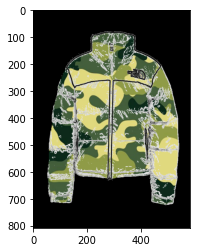

In [164]:
# TEST
details_altered = np.where(details > 235, mask_colored, details)
plt.imshow(cv2.cvtColor(details_altered, cv2.COLOR_BGR2RGB))

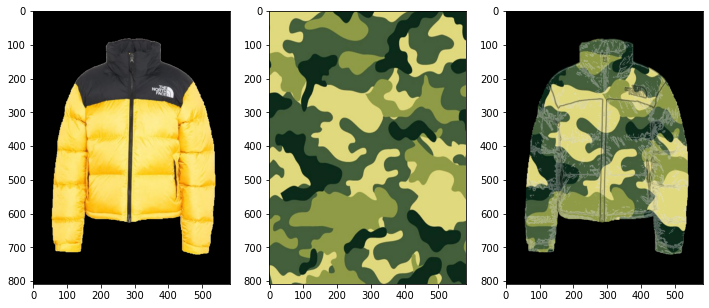

In [172]:
# weighted sum
img_colored = cv2.addWeighted(mask_colored, 0.6, details_altered, 0.4, 0, -1)

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img * mask, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_colored * mask, cv2.COLOR_BGR2RGB))

# Old version

In [94]:
color_path = '../test_imgs/camo.jpg'
img_path = '../test_imgs/jacket.jpg'
mask_path = '../test_imgs/jacket_mask.bmp'


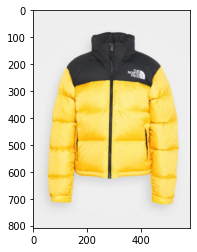

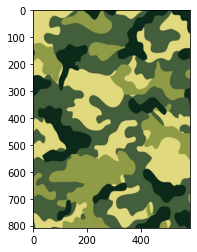

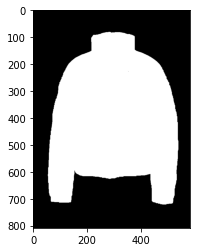

In [95]:
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color = cv2.imread(color_path)
color = cv2.resize(color, (img.shape[1], img.shape[0]))
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.imread(mask_path)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()

In [96]:
# prepare values for color multiplication
mask = np.where(mask == 255, 1, 0)
mask_complement = np.where(mask == 0, 1, 0)

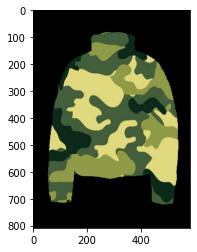

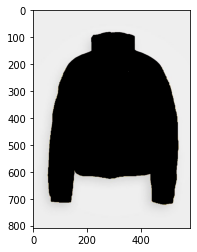

In [97]:
mask_colored = mask * color
plt.imshow(cv2.cvtColor(np.float32(mask_colored/255), cv2.COLOR_BGR2RGB))
plt.show()
# to preserve the background
mask_complement_colored = mask_complement * img
plt.imshow(cv2.cvtColor(np.float32(mask_complement_colored/255), cv2.COLOR_BGR2RGB))
plt.show()

In [98]:
# bah
img = img.astype('uint8')
mask_colored = mask_colored.astype('uint8')
mask = mask.astype('uint8')
img_colored = img.copy()

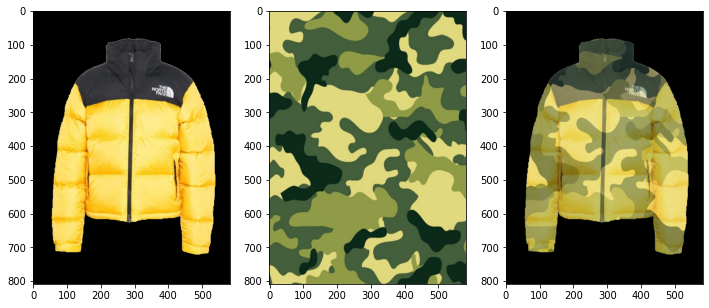

In [99]:
# weighted sum
img_colored = cv2.addWeighted(img, 0.5, mask_colored, 0.5, 0, -1)

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img * mask, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_colored * mask, cv2.COLOR_BGR2RGB))